In [1]:
%pip install matplotlib pandas torch torchvision timm qdrant_client -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!rm -rf clothing-dataset # Remove folder, if alreday exists.
!git clone https://github.com/alexeygrigorev/clothing-dataset.git

Cloning into 'clothing-dataset'...
remote: Enumerating objects: 5792, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 5792 (delta 13), reused 3 (delta 1), pack-reused 5766
Receiving objects: 100% (5792/5792), 152.92 MiB | 3.51 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (5759/5759), done.


In [3]:
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset

class ClothingImageDataset(Dataset):
  def __init__(self, img_dir='clothing-dataset/images', annotations_file='clothing-dataset/images.csv', transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0] + '.jpg')
    image = read_image(img_path)
    if self.transform:
      image = self.transform(image)
    return image, self.img_labels.iloc[idx].to_dict()

In [4]:
from torchvision.transforms import v2
from torchvision.transforms import Compose
import torch

preprocessing = v2.Compose([
    v2.ToImage(), # Converts to tensor, only needed if its a PIL image
    v2.Resize(224, ),
    v2.CenterCrop(224, ),
    v2.ToDtype(torch.float32, scale=True), # Normalize expects float input
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dataset = ClothingImageDataset(transform=preprocessing)

In [5]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
image_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


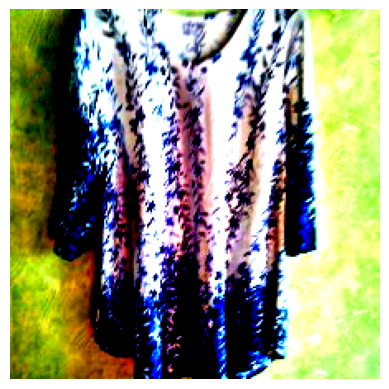

Annotation: 4285fab0-751a-4b74-8e9b-43af05deee22


In [6]:
import matplotlib.pyplot as plt

for batch_idx, (images, annotations) in enumerate(image_dataloader):

  for i, image in enumerate(images):

    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

    print(f"Annotation: {annotations['image'][i]}")
    break
  break

In [7]:
import timm
timm.list_models('vit*', pretrained=True)

/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'vit_base_patch8_224.augreg_in21k',
 'vit_base_patch8_224.augreg_in21k_ft_in1k',
 'vit_base_patch8_224.dino',
 'vit_base_patch14_dinov2.lvd142m',
 'vit_base_patch14_reg4_dinov2.lvd142m',
 'vit_base_patch16_224.augreg2_in21k_ft_in1k',
 'vit_base_patch16_224.augreg_in1k',
 'vit_base_patch16_224.augreg_in21k',
 'vit_base_patch16_224.augreg_in21k_ft_in1k',
 'vit_base_patch16_224.dino',
 'vit_base_patch16_224.mae',
 'vit_base_patch16_224.orig_in21k',
 'vit_base_patch16_224.orig_in21k_ft_in1k',
 'vit_base_patch16_224.sam_in1k',
 'vit_base_patch16_224_miil.in21k',
 'vit_base_patch16_224_miil.in21k_ft_in1k',
 'vit_base_patch16_384.augreg_in1k',
 'vit_base_patch16_384.augreg_in21k_ft_in1k',
 'vit_base_patch16_384.orig_in21k_ft_in1k',
 'vit_base_patch16_clip_224.datacompxl',
 'vit_base_patch16_clip_224.dfn2b',
 'vit_base_patch16_clip_224.laion2b',
 'vit_base_patch16_clip_224.laion2b_ft_in1k',
 'vit_base_patch16_clip_224.laion2b_ft_in12k',
 'vit_base

In [8]:
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor
model = timm.create_model('vit_base_patch8_224.augreg2_in21k_ft_in1k', pretrained=True, exportable=True)
model.default_cfg

{'url': '',
 'hf_hub_id': 'timm/vit_base_patch8_224.augreg2_in21k_ft_in1k',
 'architecture': 'vit_base_patch8_224',
 'tag': 'augreg2_in21k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 0.9,
 'crop_mode': 'center',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'patch_embed.proj',
 'classifier': 'head'}

In [9]:
nodes, _ = get_graph_node_names(model)
print(f'nodes: {nodes}')
features = {'fc_norm': 'out'}

/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


nodes: ['x', 'patch_embed.getattr', 'patch_embed.getitem', 'patch_embed.getitem_1', 'patch_embed.getitem_2', 'patch_embed.getitem_3', 'patch_embed.eq', 'patch_embed._assert', 'patch_embed.eq_1', 'patch_embed._assert_1', 'patch_embed.proj', 'patch_embed.flatten', 'patch_embed.transpose', 'patch_embed.norm', 'pos_embed', 'cls_token', 'getattr', 'getitem', 'expand', 'cat', 'add', 'pos_drop', 'patch_drop', 'norm_pre', 'blocks.0.norm1', 'blocks.0.attn.getattr', 'blocks.0.attn.getitem', 'blocks.0.attn.getitem_1', 'blocks.0.attn.getitem_2', 'blocks.0.attn.qkv', 'blocks.0.attn.reshape', 'blocks.0.attn.permute', 'blocks.0.attn.unbind', 'blocks.0.attn.getitem_3', 'blocks.0.attn.getitem_4', 'blocks.0.attn.getitem_5', 'blocks.0.attn.q_norm', 'blocks.0.attn.k_norm', 'blocks.0.attn.mul', 'blocks.0.attn.transpose', 'blocks.0.attn.matmul', 'blocks.0.attn.softmax', 'blocks.0.attn.attn_drop', 'blocks.0.attn.matmul_1', 'blocks.0.attn.transpose_1', 'blocks.0.attn.reshape_1', 'blocks.0.attn.proj', 'blocks.

In [10]:
feature_extractor = create_feature_extractor(model, return_nodes=features)
feature_extractor

VisionTransformer(
  (patch_embed): Module(
    (proj): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Module(
    (0): Module(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Module(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Module(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (

In [11]:
import qdrant_client

client = qdrant_client.QdrantClient(
    host="localhost",
    prefer_grpc=False,
)

In [12]:
from qdrant_client.http import models

VECTOR_SIZE = 768

COLLECTION_NAME = "clothing"
client.recreate_collection(
    collection_name=COLLECTION_NAME,
    vectors_config=models.VectorParams(size=VECTOR_SIZE, distance=models.Distance.COSINE)
)

# client.recreate_collection(
#     collection_name="clothing",
#     vectors_config={
#         "title": rest.VectorParams(
#             distance=rest.Distance.COSINE,
#             size=VECTOR_SIZE,
#         ),
#         "content": rest.VectorParams(
#             distance=rest.Distance.COSINE,
#             size=VECTOR_SIZE,
#         ),
#     }
# )

True

In [13]:
from qdrant_client.http import models

total_records = len(dataset)
running_counter = 0

for batch_idx, (images, annotations) in enumerate(image_dataloader):

    running_counter += (batch_idx+1) * BATCH_SIZE

    batch_of_ids = annotations['image']
    embeddings = feature_extractor(images)['out']
    batch_of_embs = embeddings.tolist()
    batch_of_payloads = []
    for values in zip(*annotations.values()):
        batch_of_payloads.append({
                'image': values[0],
                'sender_id': values[1].item(),
                'label': values[2],
                'kids': values[3].item()
        })
    # print(f"batch_of_ids: {batch_of_ids}")
    # print(f"batch_of_images: {len(batch_of_embs)}")
    # print(f"batch_of_payloads: {batch_of_payloads}")

    client.upsert(
        collection_name=COLLECTION_NAME,
        points=models.Batch(
            ids=batch_of_ids,
            vectors=batch_of_embs,
            payloads=batch_of_payloads
        )
    )
    print(f"Processed batch {batch_idx+1}, records {running_counter} out of {total_records}")
    break

/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Processed batch 1, records 64 out of 5403


In [14]:
# Check the collection size to make sure all the points have been stored
client.count(
    collection_name=COLLECTION_NAME,
    exact=True
)

CountResult(count=64)

In [15]:
client.scroll(
    collection_name=COLLECTION_NAME,
    limit=5
)

([Record(id='00627a3f-0477-401c-95eb-92642cbe078d', payload={'image': '00627a3f-0477-401c-95eb-92642cbe078d', 'kids': False, 'label': 'Not sure', 'sender_id': 94}, vector=None),
  Record(id='04b42565-23ce-47d9-8f11-e3f1fb0d5051', payload={'image': '04b42565-23ce-47d9-8f11-e3f1fb0d5051', 'kids': False, 'label': 'Top', 'sender_id': 82}, vector=None),
  Record(id='073f2d48-e363-474d-acbe-11103356e7e2', payload={'image': '073f2d48-e363-474d-acbe-11103356e7e2', 'kids': True, 'label': 'Pants', 'sender_id': 180}, vector=None),
  Record(id='08215318-faff-4037-bee9-5bceb0af7747', payload={'image': '08215318-faff-4037-bee9-5bceb0af7747', 'kids': False, 'label': 'Shoes', 'sender_id': 29}, vector=None),
  Record(id='13aa07bd-cf38-4309-8dc2-daddffe43922', payload={'image': '13aa07bd-cf38-4309-8dc2-daddffe43922', 'kids': True, 'label': 'Body', 'sender_id': 312}, vector=None)],
 '142c1548-ba32-4f34-9032-2ece7f8650ea')

In [42]:

def query_qdrant(images, collection_name, vector_name="vector", top_k=5):
    # Creates embedding vector from user query

    print(images.shape)
    embeddings = feature_extractor(images)['out']
    embedded_query = embeddings.tolist()

    query_results = client.search(
        collection_name=collection_name,
        query_vector=embedded_query[0],
        limit=top_k,
    )

    return query_results

/Users/vravuri/Projects/visual-search/.venv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


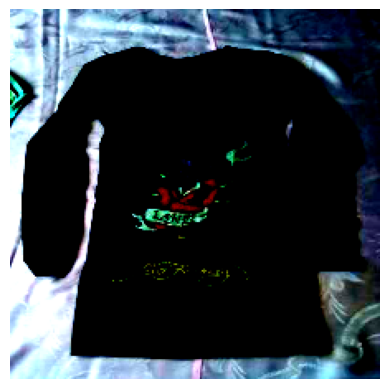

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
1. Longsleeve (Score: 1.0)
2. T-Shirt (Score: 0.826)
3. T-Shirt (Score: 0.812)
4. T-Shirt (Score: 0.806)
5. Other (Score: 0.795)


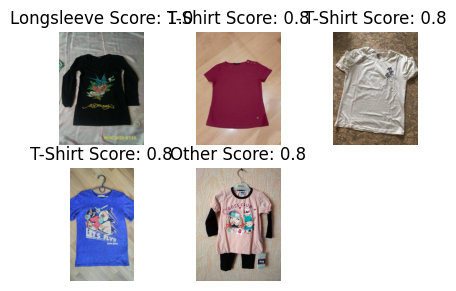

In [51]:
images, annotations = next(iter(image_dataloader))

plt.imshow(images[63].permute(1, 2, 0))
plt.axis('off')
plt.show()

search_similar_image = images[63].unsqueeze(0)
print(search_similar_image.shape)

query_results = query_qdrant(search_similar_image, COLLECTION_NAME)
for i, clothing in enumerate(query_results):
    print(f"{i + 1}. {clothing.payload['label']} (Score: {round(clothing.score, 3)})")

fig = plt.figure(figsize=(5, 5))
for i, clothing in enumerate(query_results):
    img_path = os.path.join('clothing-dataset/images', clothing.payload['image'] + '.jpg')
    image = read_image(img_path)
    axes = fig.add_subplot(3, 3, i+1)
    axes.set_axis_off()
    axes.set_title(f"{clothing.payload['label']} Score: {clothing.score:.1f}")
    plt.imshow(image.permute(1, 2, 0))
